# 🔍 Exploratory Data Analysis (EDA) — Phase 1: Data Preparation

This notebook represents the **first step** of the forest fire prediction project.  
The goal of this phase is to **prepare and explore the data** before applying any machine learning algorithms.

---

## 🧩 Objectives

In this phase, we focus on:

- **Data Preprocessing:** Handling raw environmental datasets (soil and climate data) to ensure quality and consistency.  
- **Data Integration:** Combining multiple datasets from different sources into a unified structure.  
- **Feature Engineering (Initial):** Preparing relevant features and variables for later modeling steps.

---

## 🌍 Geographic Focus

Since the study targets **North African regions**, we specifically work with:

- **Algeria** and **Tunisia** shapefiles to obtain their polygon representations.  
- **Worldwide datasets** (e.g., soil, temperature, humidity, rainfall, wind speed) clipped to these regions of interest.

---

## ⚙️ Summary of Work in This Notebook
### Tp 1 
1. **Download** the necessary datasets.  
2. **Load** and inspect them using appropriate Python libraries (`pandas`, `geopandas`, `rasterio`, etc.).  
3. **Explore** and get familiar with GeoPandas for spatial data manipulation.  
4. **Clip** the global raster and vector data to the Algeria–Tunisia region.  
5. **Prepare** the resulting data for further exploration and modeling in upcoming phases.


In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
import os
from rasterio.enums import Resampling # ✅ Import Resampling
from shapely.geometry import Point
import numpy as np
from shapely.ops import unary_union


from scripts.explore_raster import show_raster , describe_raster
from scripts.clip_raster_with_shape import clip_raster_with_shape
from scripts.plots import plot_fire_map
from scripts.concat_shapefiles import concat_shapefiles
from scripts.explore_shapefiles import describe_shapefile, show_landcover

# Concatenate for plotting
algeria_shp = gpd.read_file("../data/shapefiles/algeria/gadm41_DZA_0.shp")
tunisia_shp = gpd.read_file("../data/shapefiles/tunisia/gadm41_TUN_0.shp")
alg_tun_shp = pd.concat([algeria_shp, tunisia_shp], ignore_index=True)

alg_tun_gpd = gpd.GeoDataFrame(geometry=[unary_union(alg_tun_shp.geometry)],
                                crs=alg_tun_shp.crs)






---

## ☁️ Climate Dataset — WorldClim (1950–2024)

In this notebook, we use **historical monthly climate data** from [WorldClim](https://worldclim.org/data/monthlywth.html),  
downscaled from **CRU-TS-4.09** and bias-corrected using **WorldClim 2.1**.  
We focus on the **2020–2024** period.

### 📦 Dataset Overview
- **Variables:**  
  - **Tprec** — average precimum temperature (°C)  
  - **Tmax** — average maximum temperature (°C)  
  - **Precipitation** — total monthly rainfall (mm)
- **Resolution:** 2.5, 5, or 10 arc-precutes (~21–340 km²)
- **Format:** GeoTIFF (.tif), one file per month (120 files per 10-year block)

### 🔬 Notes
- Each raster value represents the monthly average or total for that variable.
- In this project, we **load and clip** the 2020–2024 layers to **Algeria** and **Tunisia** using `rasterio` and `geopandas`.

---


### 🧭 Exploring the Climate Dataset

For exploration purposes, we used a **climate dataset with a 5-minute spatial resolution**, containing raster layers for **maximum temperature (Tmax)**, **minimum temperature (Tmin)**, and **precipitation (Tprec)**.

To better understand the dataset structure, we explored one raster example for each variable — specifically, the file corresponding to **January 2020**.

Each raster was analyzed using the `describe_raster()` function, which provides key information such as:

- **Dimensions** → width and height of the raster in pixels.  
- **CRS (Coordinate Reference System)** → defines how the geographic coordinates are projected on Earth.  
- **Resolution** → the real-world ground size represented by each pixel.  
- **Data type** → numerical format of pixel values (e.g., `float32`, `int16`).  
- **Bounds** → the geographic extent covered by the raster (min/max longitude and latitude).  
- **Contains NaN values** → indicates whether there are missing or masked regions (for example, areas outside the study zone).

Below, the first raster of **January 2020** is displayed as an example for each climate variable to visualize the data distribution.



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 249 x 224
CRS: EPSG:4326
Resolution: 0.0833, 0.0833
Data type: float32
Bounds: (-8.75, 18.91666666666667, 12.0, 37.583333333333336)
Contains NaN values: True


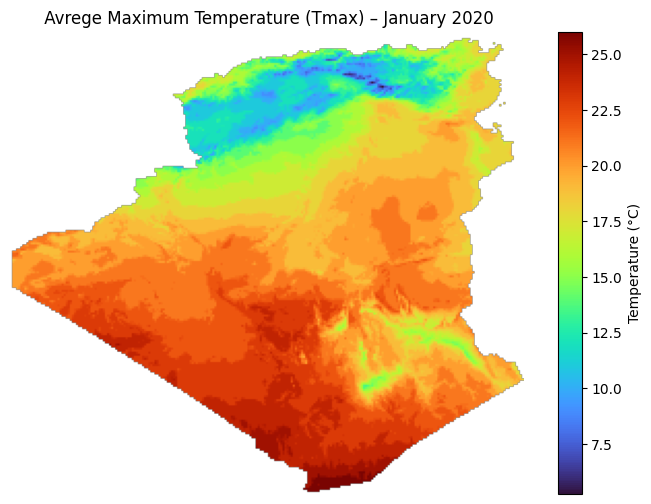

In [2]:
# === 🌡️ Exploring Maximum Temperature (Tmax) Data ===

# 1. Collect all Tmax raster file paths (sorted by date)
tmax_paths = sorted(glob.glob("../data/climate_dataset/5min/max/*.tif"))

# 2. Clip the first raster (e.g., January 2020) to Algeria–Tunisia boundary
tmax_image, tmax_transform, tmax_meta = clip_raster_with_shape(
    tmax_paths[0],
    alg_tun_gpd
)

# 3. Display raster metadata
describe_raster(tmax_image, tmax_meta, tmax_transform)

# 4. Visualize Tmax map
show_raster(
    tmax_image,
    cmap="turbo",               # good for temperature visualization
    title=" Avrege Maximum Temperature (Tmax) – January 2020",
    scale=None,
    colorbar_label="Temperature (°C)"
)



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 249 x 224
CRS: EPSG:4326
Resolution: 0.0833, 0.0833
Data type: float32
Bounds: (-8.75, 18.91666666666667, 12.0, 37.583333333333336)
Contains NaN values: True


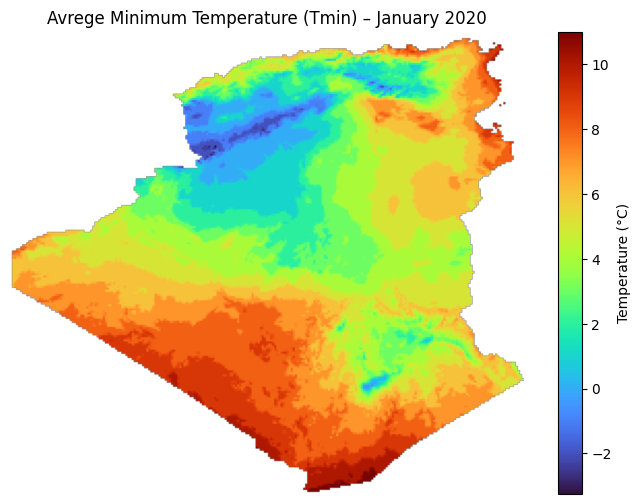

In [3]:
# === ❄️ Exploring Minimum Temperature (Tmin) Data ===

# 1. Collect all Tmin raster file paths (sorted by date)
tmin_paths = sorted(glob.glob("../data/climate_dataset/5min/min/*.tif"))

# 2. Clip the first raster (e.g., January 2020) to Algeria–Tunisia boundary
tmin_image, tmin_transform, tmin_meta = clip_raster_with_shape(
    tmin_paths[0],
    alg_tun_gpd
)

# 3. Display raster metadata
describe_raster(tmin_image, tmin_meta, tmin_transform)

# 4. Visualize Tmin map
show_raster(
    tmin_image,
    cmap="turbo",               # consistent with Tmax for comparison
    title="Avrege Minimum Temperature (Tmin) – January 2020",
    scale=None,
    colorbar_label="Temperature (°C)"
)



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 249 x 224
CRS: EPSG:4326
Resolution: 0.0833, 0.0833
Data type: float32
Bounds: (-8.75, 18.91666666666667, 12.0, 37.583333333333336)
Contains NaN values: True


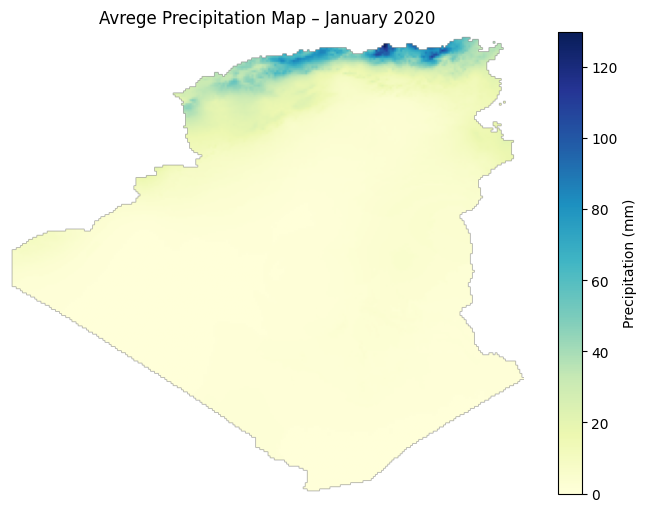

In [4]:
# === 🌧️ Exploring Precipitation (Tprec) Data ===

# 1. Collect all precipitation raster file paths (sorted by date)
tprec_paths = sorted(glob.glob("../data/climate_dataset/5min/prec/*.tif"))

# 2. Clip the first raster (e.g., January 2020) to Algeria–Tunisia boundary
tprec_image, tprec_transform, tprec_meta = clip_raster_with_shape(
    tprec_paths[0],
    alg_tun_gpd
)

# 3. Display raster metadata
describe_raster(tprec_image, tprec_meta, tprec_transform)

# 4. Visualize precipitation map
show_raster(
    tprec_image,
    cmap="YlGnBu",                 # blue-green scale suitable for precipitation
    title="Avrege Precipitation Map – January 2020",
    scale=None,
    colorbar_label="Precipitation (mm)"
)


---
# 🏔️ Elevation Dataset — GMTED2010

The **Global Multi-resolution Terrain Elevation Data 2010 (GMTED2010)** is a global digital elevation model developed by the **USGS** and **NGA**.  
It provides detailed topographic information at **7.5-, 15-, and 30-arc-second resolutions**, covering most of the Earth’s land surface between **84°N and 56°S** (and globally for some products).

The dataset offers several elevation products such as **mean, minimum, maximum, median, and standard deviation** of elevation values, derived from the best available global data sources.  
It significantly improves upon the older **GTOPO30** model, achieving a global vertical accuracy of around **6 meters RMSE**.


In this project, the GMTED2010 dataset is used to visualize and analyze the **elevation patterns** across Algeria and Tunisia.
You can learn more or download the dataset from the [USGS GMTED2010 official page](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-multi-resolution-terrain-elevation).



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 4960 x 4465
CRS: EPSG:4326
Resolution: 0.0042, 0.0042
Data type: int16
Bounds: (-8.675138888889023, 18.958194444444377, 11.99152777777763, 37.56236111111103)
Contains NaN values: True


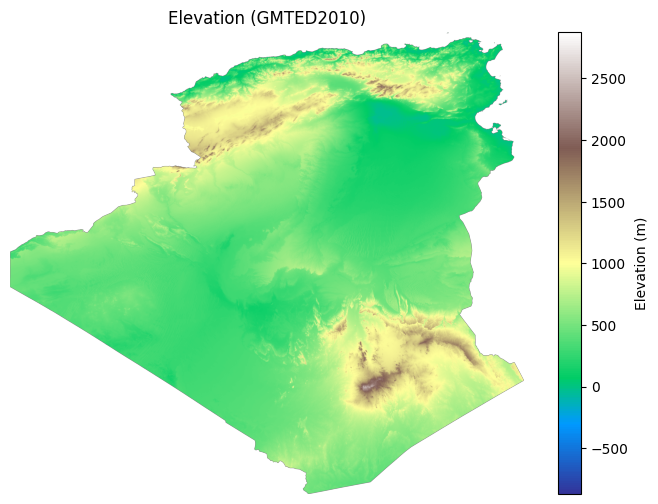

In [5]:
# === 🏔️ Exploring Elevation Data (GMTED2010) ===

# 1️⃣ Load the elevation raster file
elevation_file = "../data/elevation_dataset/be15_grd/w001001.adf"

# 2️⃣ Clip the raster to the Algeria–Tunisia boundary
elevation_image, elevation_transform, elevation_meta = clip_raster_with_shape(
    elevation_file,
    alg_tun_gpd
)

# 3️⃣ Display raster metadata
describe_raster(elevation_image, elevation_meta, elevation_transform)

# 4️⃣ Visualize the elevation map
show_raster(
    elevation_image,
    cmap="terrain",          # color scale suitable for elevation
    title="Elevation (GMTED2010)",
    scale=None,
    colorbar_label="Elevation (m)"
)


---
## 🟩 Land Cover Dataset — Algeria & Tunisia (Globcover Regional, 2005)

For this project, we used the **Globcover Regional (Africa)** land cover datasets for **Algeria** and **Tunisia**, derived from the original *Globcover 2005* raster archive developed by the **European Space Agency (ESA)** and reprocessed by the **Global Land Cover Network (GLCN)**.

These datasets provide detailed land cover information at a **300 m spatial resolution**, covering 46 land cover classes based on the **Land Cover Classification System (LCCS)**.  
They are provided in **vector format (ESRI shapefile)**, allowing analysis and visualization of land cover types at the national and regional scale.

Each shapefile includes the following key attributes:
- **Area (sqm)** — polygon area in square meters  
- **ID** — unique identifier  
- **Gridcode** — Globcover cell value  
- **LCCCode** — unique Land Cover Classification System code  

🗓 **Data Year:** 2005  
🗂 **Creation Date:** 2022-12-13  
📏 **Spatial Resolution:** 300 m  
🌍 **Coverage:** National (Algeria & Tunisia)  
📖 **Legend:** 46 land cover classes (LCCS regional legend)

These datasets are ideal for environmental studies, land use mapping, and natural resource management.  
They can also be analyzed with the **Advanced Database Gateway (ADG)** software provided by GLCN, which allows users to aggregate or reclassify land cover categories.

🔗 **Sources:**
- [FAO Data Portal – Land Cover (Algeria)](https://data.apps.fao.org/catalog/iso/0e958049-2a0a-4935-83c8-af78626068fc)  
- [FAO Data Portal – Land Cover (Tunisia)](https://data.apps.fao.org/catalog/iso/d0ba96c7-786c-4f3f-bbd9-e427b3b23d2d)


In [6]:
# === Combine Algeria and Tunisia landcover shapefiles ===
alg_tun_shp_landcvr = concat_shapefiles(
    "../data/land_dataset/algeria/dza_gc_adg.shp",
    "../data/land_dataset/tunisia/tun_gc_adg.shp"
)

# === Describe the combined shapefile ===
print("✅ Combined Algeria–Tunisia landcover shapefile created successfully!\n")
describe_shapefile(alg_tun_shp_landcvr)


✅ Combined Algeria–Tunisia landcover shapefile created successfully!


🗺️ Exploring shapefile: GeoDataFrame
CRS: EPSG:4326
Number of features: 438513
Geometry types: ['Polygon']
Bounds: [-8.67386723 18.96002769 11.97954845 37.54393005]
Columns: ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry', 'AREA_M2', 'LCCCode']

📋 Attribute summary:
             count unique          top    freq            mean  \
ID        438513.0    NaN          NaN     NaN   173378.294498   
GRIDCODE  438513.0    NaN          NaN     NaN      156.209934   
AREA      386454.0    NaN          NaN     NaN  5994332.451854   
LCCCODE     386454     22         0011  168143             NaN   
AREA_M2    52059.0    NaN          NaN     NaN   2981264.94487   
LCCCode      52059     20  0003 / 0004    8776             NaN   

                        std       min       25%        50%         75%  \
ID            117981.553876       1.0   57570.0   167198.0    276826.0   
GRIDCODE          65.661496      14.0     150.0   

d:\usthb\M2\DataMining\projet\DataMining--Project\src\scripts\explore_shapefiles.py:124: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


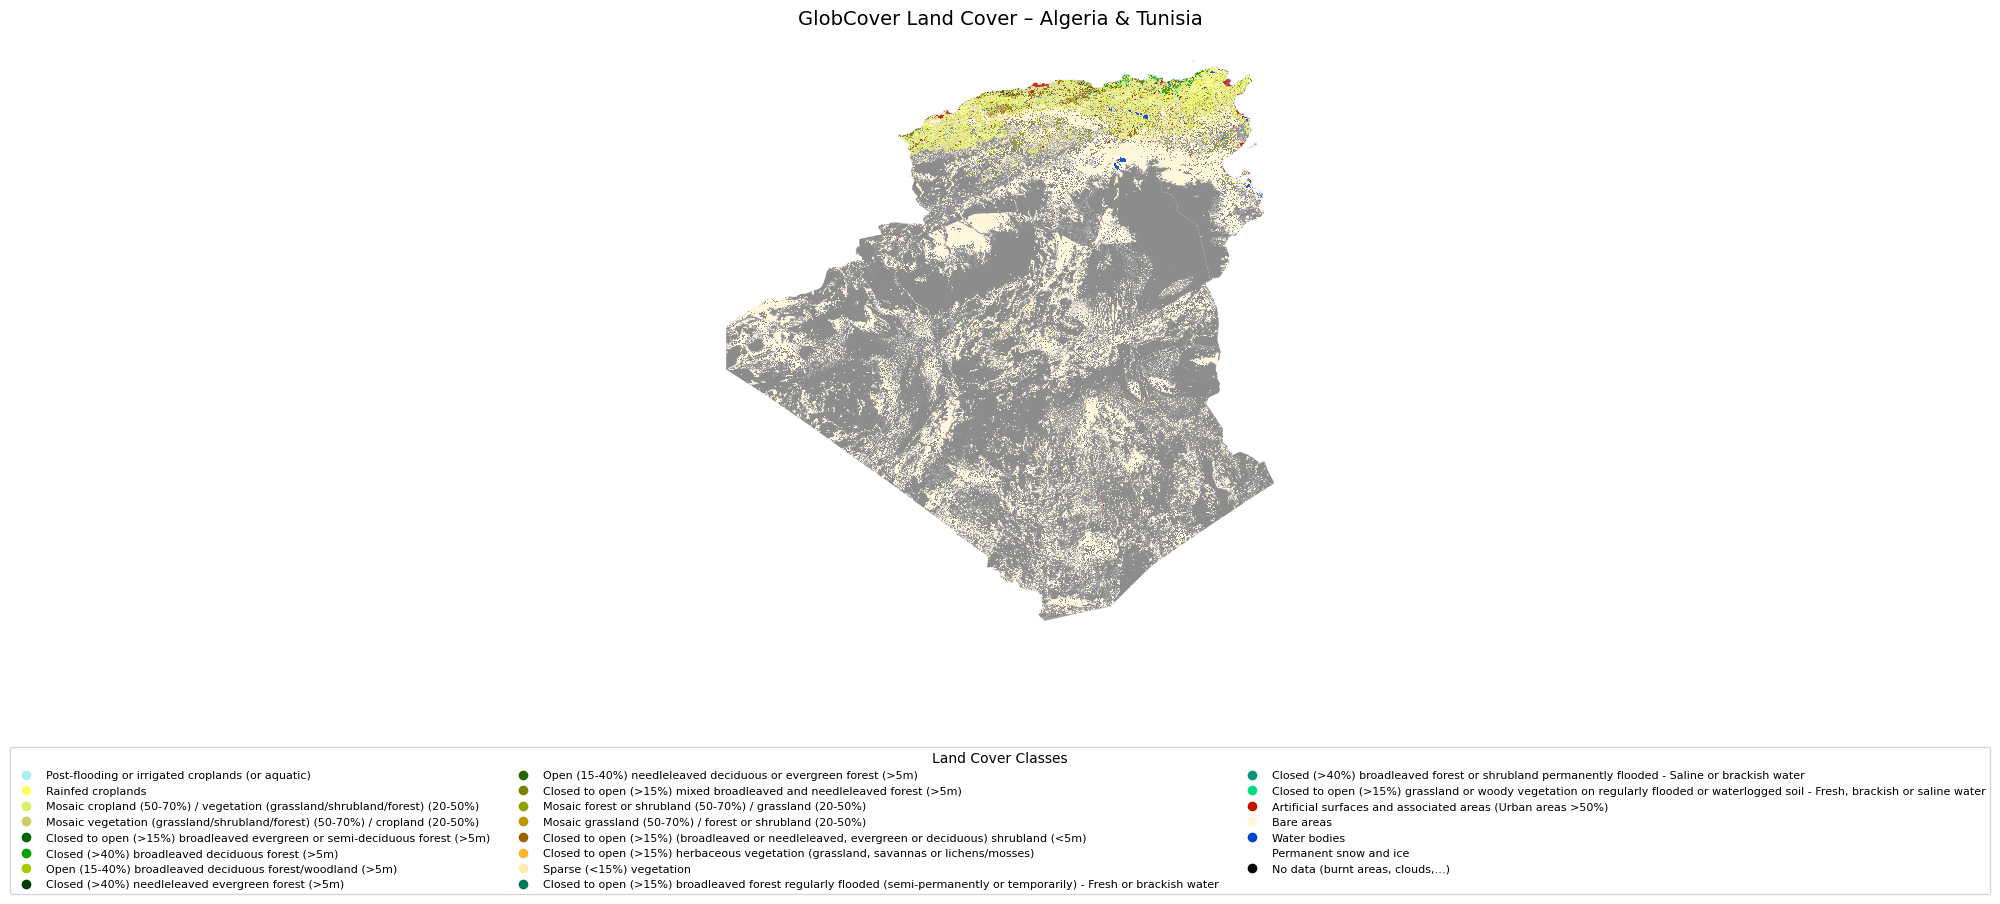

In [7]:
# === Display Combined Land Cover Map (Algeria & Tunisia) ===
show_landcover(
    source=alg_tun_shp_landcvr,
    legend_path="../data/land_dataset/algeria/globcover_legend.xls",
    code_column="GRIDCODE",
    title="GlobCover Land Cover – Algeria & Tunisia",
)


---
## 🔥 Fire Hotspots Dataset (NASA FIRMS)

For this exploration, we used the **Fire Information for Resource Management System (FIRMS)** dataset provided by **NASA** — available at [firms.modaps.eosdis.nasa.gov](https://firms.modaps.eosdis.nasa.gov/country/).

This dataset contains information on **active fire detections** captured by the MODIS and VIIRS satellite instruments.  
Each record corresponds to a detected fire pixel, with attributes describing its geographic location, brightness, time of acquisition, and confidence level.

**Key Columns:**
- **latitude, longitude** → Geographic coordinates of the detected fire.  
- **bright_ti4 / bright_ti5** → Brightness temperatures (in Kelvin) from different thermal bands.  
- **scan, track** → Dimensions of the satellite scan and track at the fire pixel.  
- **acq_date, acq_time** → Date and local time when the fire was detected.  
- **satellite** → Indicates the satellite source (e.g., Aqua, Terra, or Suomi NPP).  
- **instrument** → Sensor used for detection (MODIS or VIIRS).  
- **confidence** → Confidence level (%) of fire detection.  
- **frp** → Fire Radiative Power (MW), a measure of fire intensity.  
- **daynight** → Indicates if the detection occurred during **day** or **night**.  
- **type** → Type of fire detection (e.g., active fire, presumed fire, etc.).  

This dataset enables monitoring and analysis of fire activity across regions, useful for understanding temporal and spatial fire patterns.


✅ Fire data loaded: 90250 total rows


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,27.72818,9.87200,295.51,0.76,0.77,2024-01-01,3,N20,VIIRS,n,2,277.66,1.24,N,2
1,28.63288,9.77909,301.80,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.05,1.57,N,2
2,28.64012,9.77953,298.65,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.04,1.34,N,2
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141,N20,VIIRS,n,2,257.28,5.21,N,2
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141,N20,VIIRS,n,2,272.08,1.58,N,2


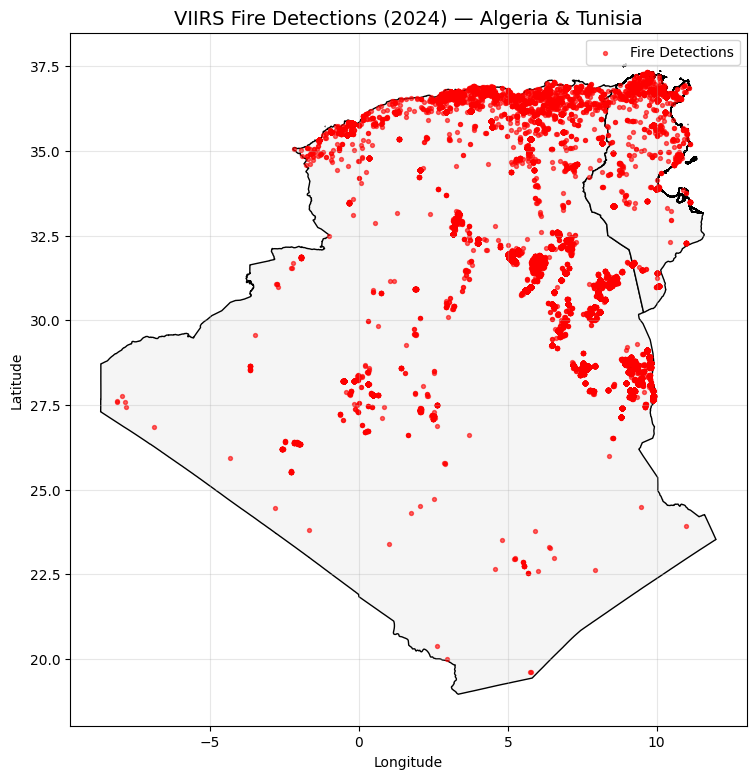

In [8]:


#  Load the fire datasets for Algeria and Tunisia ---
fire_alg_path = "../data/fire_dataset/viirs-jpss1_2024_Algeria.csv"
fire_tun_path = "../data/fire_dataset/viirs-jpss1_2024_Tunisia.csv"

fire_alg = pd.read_csv(fire_alg_path)
fire_tun = pd.read_csv(fire_tun_path)

# Combine both datasets
fire_df = pd.concat([fire_alg, fire_tun], ignore_index=True)
print(f"✅ Fire data loaded: {len(fire_df)} total rows")
display(fire_df.head())


#  Convert fire detections to a GeoDataFrame ---
geometry = [Point(xy) for xy in zip(fire_df["longitude"], fire_df["latitude"])]
fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")  # WGS84



# Plot the combined fire detections ---
plot_fire_map(alg_tun_shp, fire_gdf, title="VIIRS Fire Detections (2024) — Algeria & Tunisia")


## 🌱 Harmonized World Soil Database v2.0 — Soil Attributes

The **HWSD v2.0** provides detailed soil information for nearly 30,000 **Soil Mapping Units (SMUs)** globally. Each SMU contains multiple attributes describing **soil classification, physical, chemical, and morphological properties**.

- **ROOT_DEPTH** – maximum depth roots can grow  
- **BULK_DENSITY** – soil density  
- **AWC** – available water capacity  
- **DRAINAGE** – soil drainage class  
- **TEXTURE_USDA** – soil texture (sand, silt, clay composition)  
- **FAO90** – FAO soil classification  
- **WRB4 / WRB_PHASES / WRB2** – soil reference classifications  
- **COVERAGE & SHARE** – how much of the area each soil unit covers  
- **KOPPEN** – climate classification for the soil unit  
- **PHASE1 / PHASE2** – soil phases or special characteristics  
- **ROOTS** – root system type  
- **ADD_PROP** – other additional soil properties  

🔗 **Source:** [FAO – HWSD v2.0](https://www.fao.org/soils-portal/data-hub/soil-maps-and-databases/harmonized-world-soil-database-v20/en/)


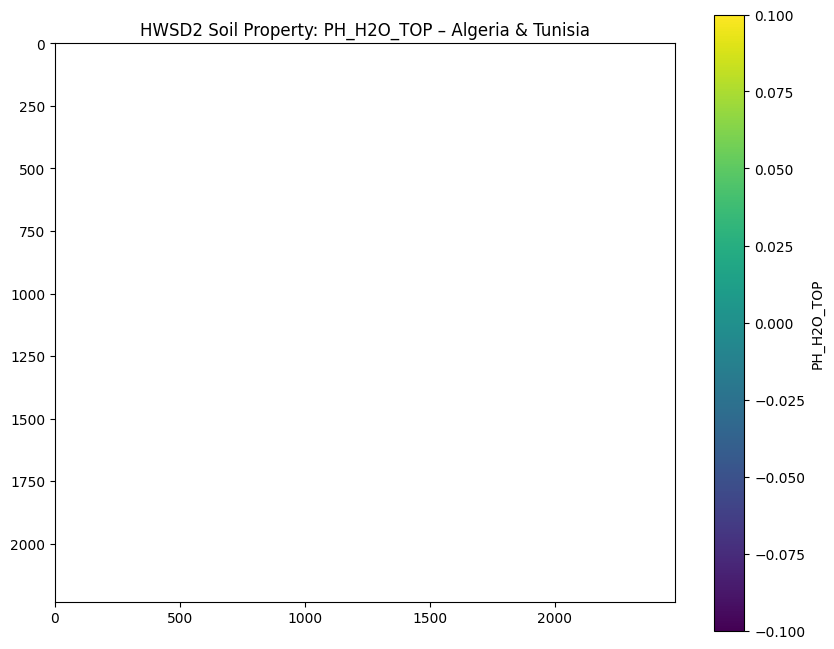

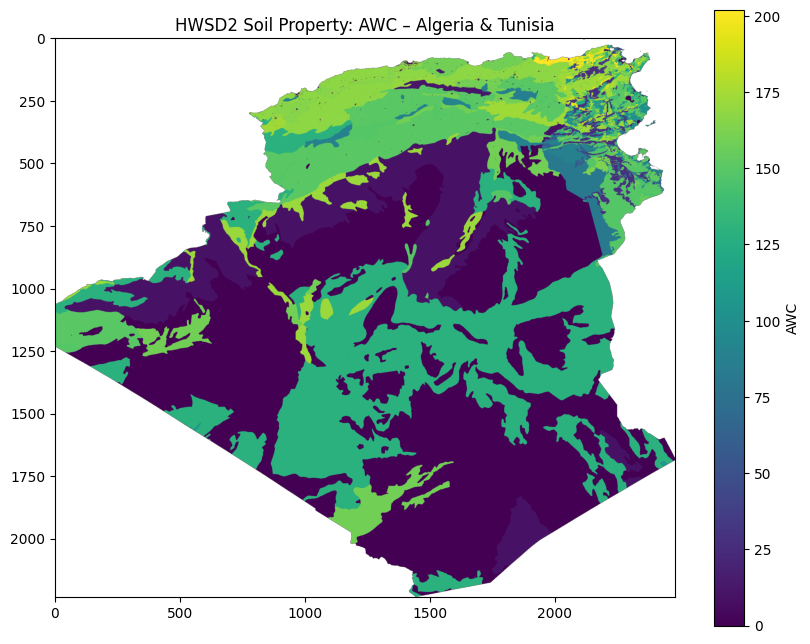

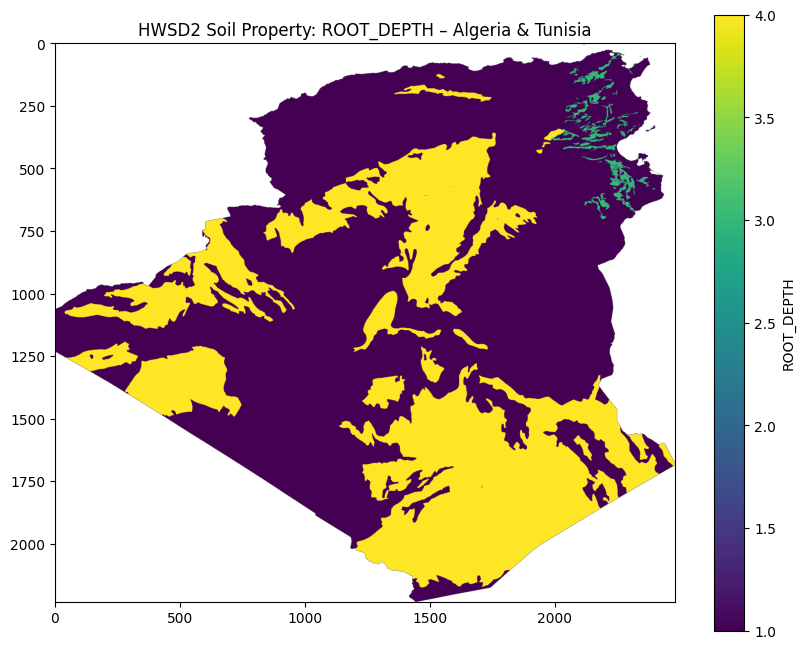

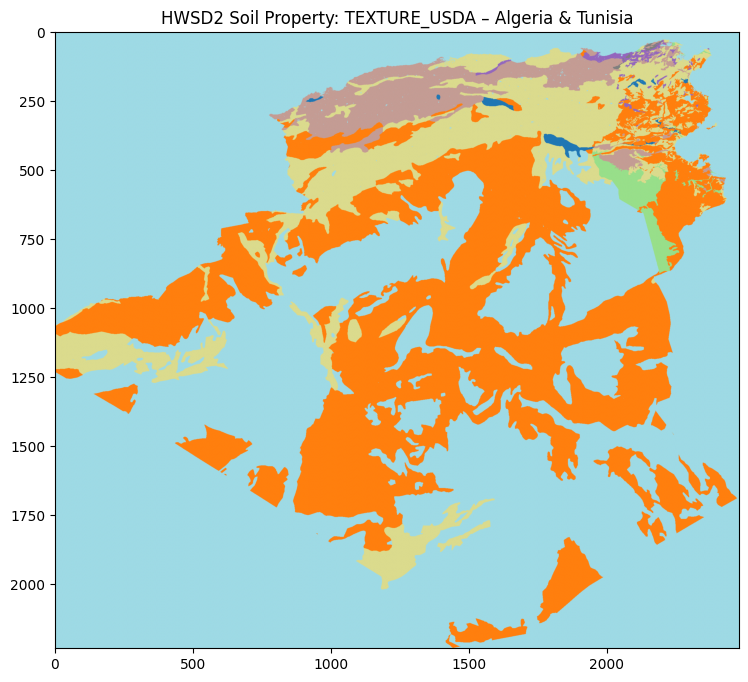

In [16]:
# === 🪴 HWSD2 Soil Properties Maps for Algeria & Tunisia ===

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pyodbc

# === 1. Paths ===
hwsd_raster_path = "../data/soil_dataset/HWSD2_RASTER/HWSD2.bil"
hwsd_mdb_path = r"../data/soil_dataset/HWSD2.mdb"  # absolute path
# alg_tun_gpd is your Algeria + Tunisia GeoDataFrame

# === 2. Clip raster to Algeria & Tunisia ===
hwsd_image, hwsd_transform, hwsd_meta = clip_raster_with_shape(
    hwsd_raster_path,
    alg_tun_gpd
)

# === 3. Connect to MDB and read HWSD2_SMU ===
conn_str = (
    r"Driver={Microsoft Access Driver (*.mdb, *.accdb)};"
    fr"DBQ={hwsd_mdb_path};"
)
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Fetch all SMU rows
cursor.execute("SELECT * FROM HWSD2_SMU")
columns = [col[0] for col in cursor.description]
smu_rows = [dict(zip(columns, row)) for row in cursor.fetchall()]
conn.close()

# Build a dictionary mapping ID -> properties
smu_dict = {row["HWSD2_SMU_ID"]: row for row in smu_rows}

# === 4. Prepare property rasters ===
# Numeric properties
numeric_props = ["PH_H2O_TOP", "AWC", "ROOT_DEPTH"]
property_rasters = {p: np.full(hwsd_image.shape, np.nan) for p in numeric_props}

# Categorical property
texture_map = np.full(hwsd_image.shape, "", dtype=object)

rows, cols = hwsd_image.shape

# Fill property arrays safely
for r in range(rows):
    for c in range(cols):
        su_val = hwsd_image[r, c]
        if not np.isnan(su_val):
            su_id = int(su_val)
            if su_id in smu_dict:
                smu = smu_dict[su_id]
                # numeric properties
                for p in numeric_props:
                    val = smu.get(p)
                    if val is not None:
                        property_rasters[p][r, c] = float(val)
                # texture
                texture_map[r, c] = smu.get("TEXTURE_USDA", "")


# === 5. Plot numeric properties ===
for prop in numeric_props:
    plt.figure(figsize=(10, 8))
    plt.imshow(property_rasters[prop], cmap="viridis")
    plt.colorbar(label=prop)
    plt.title(f"HWSD2 Soil Property: {prop} – Algeria & Tunisia")
    plt.show()

# === 6. Plot texture (categorical) ===
# Make sure all entries are strings
texture_map_safe = np.where((texture_map == "") | (texture_map == None), "NoData", texture_map).astype(str)
unique_textures = np.unique(texture_map_safe)

cmap = plt.get_cmap("tab20", len(unique_textures))
texture_colors = {tex: cmap(i) for i, tex in enumerate(unique_textures)}

# Convert texture_map to RGB array
texture_rgb = np.zeros((rows, cols, 3))
for r in range(rows):
    for c in range(cols):
        tex = texture_map_safe[r, c]
        texture_rgb[r, c] = texture_colors.get(tex, (0,0,0))[:3]

plt.figure(figsize=(10, 8))
plt.imshow(texture_rgb)
plt.title("HWSD2 Soil Property: TEXTURE_USDA – Algeria & Tunisia")
plt.show()

